In [2]:
import pandas as pd
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

display(df.head())

KeyboardInterrupt: 

In [50]:
#optimizing neural network
import pandas as pd
from sklearn.model_selection import train_test_split       #automatically shuffle
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image
import numpy as np
import torchvision.models as models


In [51]:

# set manual seed for reproduciblitly
torch.manual_seed(42)

In [52]:
df = pd.read_csv('fmnist_small.csv')

In [53]:
df.shape

(6000, 785)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

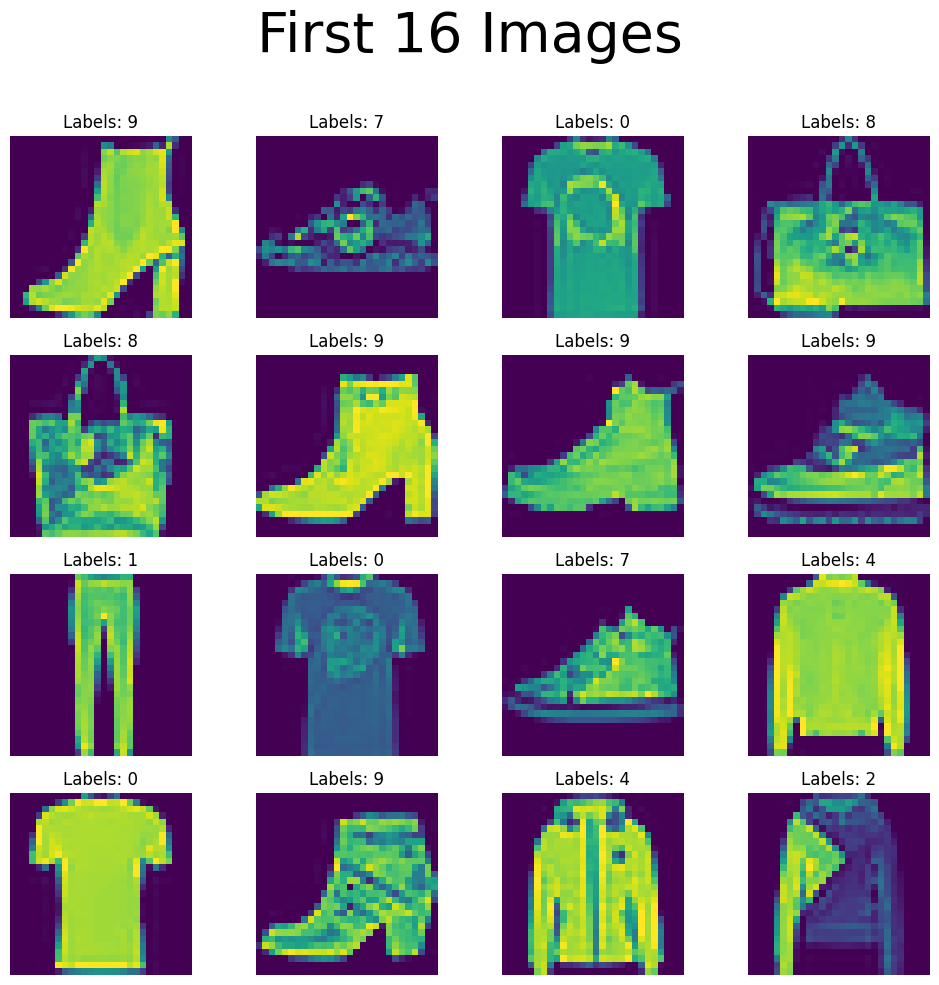

In [55]:
# create a 4x4 grid of images
fig, axes  = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize = 40)

#plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  #reshape to 28x28
    ax.imshow(img)    #display the grayscale
    ax.axis('off')
    ax.set_title(f"Labels: {df.iloc[i, 0]}")

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()

In [56]:
x = df.iloc[: , 1:].values
y = df.iloc[: , 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
# x_train = x_train/255.0
# x_test = x_test/255.0

In [57]:
# transformations
custom_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48235, 0.45882, 0.40784], std = [0.00392156862745098, 0.00392156862745098, 0.00392156862745098])

])

In [68]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
      return len(self.features)

    def __getitem__(self, index):

      # resize to (28 , 28)
      image = self.features[index].reshape(28, 28)

      # change datatype to np.uint8
      image = image.astype(np.uint8)


      # change black and white to color -> (H, W, C)
      image = np.stack([image]*3, axis = -1)

      # convet array to pil image
      image = Image.fromarray(image)

      # apply transforms
      image = self.transform(image)

      # return
      return image, torch.tensor(self.labels[index], dtype = torch.long)


In [69]:

# create train_dataset object
train_dataset = CustomDataset(x_train, y_train, transform=custom_transforms)
# create test dataset
test_dataset = CustomDataset(x_test, y_test, transform=custom_transforms)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory=True)

In [70]:
vgg16 = models.vgg16(pretrained = True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [72]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [73]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [74]:
# vgg16

In [75]:
vgg16 = vgg16.to(device)

In [76]:
# class MyNN(nn.Module):
#     def __init__(self, input_features):
#         super().__init__()
#         # self.model = nn.Sequential(
#         #     nn.Linear(num_features, 128),
#         #     nn.BatchNorm1d(128),
#         #     nn.ReLU(),
#         #     nn.Dropout(p=0.5),
#         #     nn.Linear(128,64),
#         #     nn.BatchNorm1d(64),
#         #     nn.ReLU(),
#         #     nn.Dropout(p=0.5),
#         #     nn.Linear(64, 10)
#         # )
#         self.features = nn.Sequential(
#             nn.Conv2d(input_features, 32, kernel_size = 3, padding = 'same'),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size = 2, stride=2),

#             nn.Conv2d(32, 64, kernel_size = 3, padding = 'same'),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size = 2, stride=2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64*7*7, 128),
#             nn.ReLU(),
#             nn.Dropout(p=0.4),

#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(p=0.4),
#             nn.Linear(64, 10)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

In [77]:
learning_rate = 0.0001
epochs = 10
# instantiate the model
# model = MyNN(x_train.shape[1])

# model = MyNN(1)
# model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr = learning_rate, weight_decay=1e-4)
# len(train_loader)

In [78]:
# training loop
for epoch in range(epochs):

    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features , batch_labels = batch_features.to(device), batch_labels.to(device)
        # forward pass
        outputs = vgg16(batch_features)


        # calculate loss
        loss = criterion(outputs, batch_labels)


        # backpropagation
        optimizer.zero_grad()
        loss.backward()


        # update gradients
        optimizer.step()
        total_epoch_loss+= loss.item()
    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epoch: {epoch+1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 1.189158134261767
Epoch: 2 , Loss: 0.636364436050256
Epoch: 3 , Loss: 0.5007979092001915
Epoch: 4 , Loss: 0.3745438250899315
Epoch: 5 , Loss: 0.3159162334104379
Epoch: 6 , Loss: 0.28749545991420744
Epoch: 7 , Loss: 0.22343510294953983
Epoch: 8 , Loss: 0.19464173452307781
Epoch: 9 , Loss: 0.15308911771823963
Epoch: 10 , Loss: 0.1280870229502519


In [79]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [80]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features , batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = vgg16(batch_features)
        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted==batch_labels).sum().item()

print(correct/total)

0.8608333333333333


In [81]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features , batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = vgg16(batch_features)
        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted==batch_labels).sum().item()

print(correct/total)

0.994375


# overfitting

In [ ]:
from google.colab import files

print("Please select your zipped folder for upload.")
uploaded = files.upload()

# Assuming you uploaded a single zip file
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        zip_file_name = filename
        print(f'Uploaded file: {zip_file_name}')
    else:
        print(f'Uploaded file {filename} is not a zip file. Please upload a .zip file.')
        zip_file_name = None
        break

if zip_file_name:
    # Unzip the file. The -d flag specifies the destination directory.
    # If you want to extract to the current directory, you can omit '-d target_directory'
    # or use '-d .'
    import zipfile
    import os

    print(f'Extracting {zip_file_name}...')
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall('.') # Extracts all contents to the current directory
    print('Extraction complete!')
    # Optionally, list the contents to verify
    print('Contents after extraction:')
    print(os.listdir('.'))


Please select your zipped folder for upload.


Saving .gitattributes to .gitattributes
Saving .gitignore to .gitignore
Saving experimental.py to experimental.py
Saving README.md to README.md
Saving stylize.py to stylize.py
Saving train.py to train.py
Saving transformer.py to transformer.py
Saving utils.py to utils.py
Saving vgg.py to vgg.py
Saving video.py to video.py
Saving webcam.py to webcam.py
Uploaded file .gitattributes is not a zip file. Please upload a .zip file.
